### Dynamic College and Labor Supply Model

This model describes an individual’s lifetime decision between **education** and **working**, accounting for **consumption**, **savings** and **human capital accumulation**.

At the initial period \( t = 0 \), the agent chooses whether to attend college or enter the labor market, comparing the expected values of each path. If college is chosen, the agent consumes while incurring education costs and increasing human capital. Upon graduation, the agent enters the labor market, deciding how much to **consume** and **work**, with wages depending on accumulated human capital.

- If **college** is chosen, the agent remains a student for $ t_{\text{college}} = 4 $ years, during which they **consume**, **pay tuition**, and **accumulate human capital**. The psychic cost $ \kappa_X $ is also incurred each year.
- After graduation, at time $t + t_{\text{college}}$, the agent enters the **labor market** with enhanced human capital and starts making labor supply decisions.

- If **work** is chosen directly, the agent starts earning immediately and decides each period how much to **consume** and **work**, while human capital grows on-the-job.

---


#### Initial Decision ($t = 0$)


$$
V_0(X, I) = \max \left\{ \mathbb{E} \left[ V^E\right], \mathbb{E} \left[ V^W \right] \right\}
$$

#### College ($s_t = E$)




$$
V^E _t(E, A_t, k_t, z_t, \epsilon_t) = \max_{c_t} \left\{ \frac{c_t^{1-\rho}}{1-\rho} - \kappa_X + \beta \mathbb{E} \left[ V^W _{t+1}(s_{t+1}, e, A_{t+1}, k_{t+1}\, u_{t+1}) \right] \right\}
$$

$$
A_{t+1} = (1 + r) . A_t - c_t - \it{college cost}
$$

$$
k_{t+1} = k_t + h_t^E
$$



#### Labor Market ($s_t = W$)



$$
V^W _t(W, e, A_t, k_t, 0) = \max_{c_t, h_t} \left\{ \frac{c_t^{1-\rho}}{1-\rho} -\varphi \frac{h_t^{1+\eta}}{1+\eta} + \beta \mathbb{E} \left[ V^W _{t+1}(W, e, A_{t+1}, k_{t+1}, u_{t+1}) \right] \right\}
$$

$$
A_{t+1} = (1 + r). A_t + (1 - \tau_{\text{tax}}) w_t h_t - c_t
$$

$$
w_t = w_0(1 + \alpha k_t)
$$

$$
k_{t+1} = k_t + h_t
$$

---

### Model Parameter Settings

| **Parameter**     | **Value**                             | **Description**                                                     |
|------------------|-----------------------------------------|---------------------------------------------------------------------|
| `T`              | 50                                      | Number of periods (e.g., age 18 to 68)                              |
| `t_college`      | 4                                       | Duration of college before entering the labor market                |
| `β` (`beta`)     | 0.96                                    | Discount factor (annual)                                            |
| `ρ` (`rho`)      | 1.8                                    | Relative risk aversion (CRRA utility)                               |
| `η` (`eta`)      | 0.5                                     | Inverse Frisch elasticity (elasticity ≈ 2)    |
| `ϕ` (`phi`)      | 1.0                                    | Weight on disutility of labor                                       |
| `r`              | 0.03                                    | Real interest rate (annual)                                         |
| `w_0`            | 30,000                                  | Base wage (e.g., starting wage at age 18)                           |
| `α` (`alpha`)    | 0.1                                    | Wage increase per year of human capital (education or experience)   |
| `τ_tax`          | 0.25                                    | Labor income tax rate                                 |
| `κ_X` (`kappa_X`)| 3,000                                   | Annual psychic cost of attending college                            |
| `college cost`   | 12,000                                  | Annual direct college cost              |
| `college boost`          | 4.0                                    | Human capital gain per year of education (1 unit per year)          |
| `a_max`          | 1,000,000                                 | Maximum asset level in grid                                         |
| `Na`             | 100                                     | Number of grid points for assets                                    |
| `Nk`             | 50                                      | Number of grid points for human capital                             |
| `k_grid`         | `nonlinspace(0.0, 30.0, Nk, 1.1)`       | Human capital grid: up to 30 years of experience/schooling          |
| `a_grid`         | `nonlinspace(0.0, a_max, Na, 2.0)`      | Asset grid with finer resolution near zero                          |




### Setup

In [2]:
using Random, NLopt, LinearAlgebra, Interpolations, Base.Threads
using Plots, Statistics, ProgressMeter, ForwardDiff, Distributions, Profile

### Model

In [65]:
# -------------------------------
# Utility: Nonlinear Grid Creator
# -------------------------------
function nonlinspace(start::Float64, stop::Float64, num::Int, curv::Float64)
    lin_vals = range(0, stop=1, length=num)
    curved_vals = lin_vals .^ curv
    return start .+ (stop - start) .* curved_vals
end

# -------------------------------
# Dynamic Labor Model Definition with college Descison
# -------------------------------

mutable struct ConSavLaborCollege
    T::Int
    t_college::Int
    rho::Float64
    beta::Float64
    phi::Float64
    eta::Float64
    alpha::Float64
    w::Float64
    tau::Float64
    r::Float64
    a_max::Float64
    a_min::Float64
    Na::Int
    k_max::Float64
    Nk::Int
    simT::Int
    simN::Int
    a_grid::Vector{Float64}
    k_grid::Vector{Float64}
    sol_c_work::Array{Float64, 3}
    sol_h_work::Array{Float64, 3}
    sol_v_work::Array{Float64, 3}

    sol_c_college::Array{Float64, 3}
    sol_h_college::Array{Float64, 3}
    sol_v_college::Array{Float64, 3}

    sim_c::Matrix{Float64}
    sim_h::Matrix{Float64}
    sim_assets::Matrix{Float64}
    sim_labor::Matrix{Float64}
    sim_a_init::Vector{Float64}
    sim_k_init::Vector{Float64}
    draws_uniform::Matrix{Float64}
    w_vec::Vector{Float64}
    college_cost::Float64
    college_boost::Float64
end

# -------------------------------
# Constructor for ConSavLaborCollege
# -------------------------------
function ConSavLaborCollege(; 
    T::Int=50, t_college::Int=4, beta::Float64=0.96, rho::Float64=1.8, 
    r::Float64=0.02, a_max::Float64=1000000.0, Na::Int=100, 
    simN::Int=5000, a_min::Float64=0.0, k_max::Float64=20.0, Nk::Int=50, 
    w::Float64=30000.0, tau::Float64=0.25, eta::Float64=0.5, alpha::Float64=0.1, 
    phi::Float64=1.0, seed::Int=1234, college_cost::Float64=12000.0, 
    college_boost::Float64=4.0)
    simT = T
     # --- Grids for state variables and decisions ---
    a_grid = nonlinspace(a_min, a_max, Na, 2.0)
    k_grid = nonlinspace(0.0, k_max, Nk, 1.1)


    sol_c_work = fill(NaN, (T, Na, Nk))
    sol_h_work = fill(NaN, (T, Na, Nk))
    sol_v_work = fill(NaN, (T, Na, Nk))

    sol_c_college = fill(NaN, (T, Na, Nk))
    sol_h_college = fill(NaN, (T, Na, Nk))
    sol_v_college = fill(NaN, (T, Na, Nk))


    sim_c = fill(NaN, (simN, simT))
    sim_h = fill(NaN, (simN, simT))
    sim_assets = fill(NaN, (simN, simT))
    sim_labor = fill(NaN, (simN, simT))
    sim_a_init = zeros(Float64, simN)
    sim_k_init = zeros(Float64, simN)

    w_vec = fill(w, T)
    rng = MersenneTwister(seed)
    draws_uniform = rand(rng, simN, simT)
    

    return ConSavLaborCollege(
        T, t_college, rho, beta, phi, eta, alpha, w, tau, r,
        a_max, a_min, Na, k_max, Nk, simT, simN, a_grid, k_grid,
        sol_c_work, sol_h_work, sol_v_work, sol_c_college, sol_h_college, sol_v_college,
         sim_c, sim_h, sim_assets, sim_labor,
        sim_a_init, sim_k_init, draws_uniform, w_vec, college_cost, college_boost
    )
end


ConSavLaborCollege

In [66]:
# --------------------------
# Model Solver
# --------------------------
function solve_model_college!(model::ConSavLaborCollege)
    T, Na, Nk = model.T, model.Na, model.Nk
    a_grid, k_grid = model.a_grid, model.k_grid
    sol_c, sol_h, sol_v = model.sol_c_college, model.sol_h_college, model.sol_v_college

    # Final period: t = T
    for i_a in 1:Na
        for i_k in 1:Nk
            assets = a_grid[i_a]
            capital = k_grid[i_k]
            function obj_last(h_vec::Vector, grad::Vector)
                return obj_last_period(model, h_vec[1], assets, capital, T)
            end
            opt = Opt(:LN_COBYLA, 1)
            lower_bounds!(opt, [0.0])
            upper_bounds!(opt, [1.0])
            xtol_rel!(opt, 1e-4)
            min_objective!(opt, obj_last)
            init = [0.5]
            (minf, h_vec, ret) = optimize(opt, init)
            h_opt = h_vec[1]
            cons = assets + wage_func(model, capital, T) * h_opt
            sol_h[T, i_a, i_k] = h_opt
            sol_c[T, i_a, i_k] = cons
            sol_v[T, i_a, i_k] = -minf
        end
    end

    # Work periods: t = T-1 to t_college + 1
    @showprogress 1 "Solving college periods..." for t in (T-1):-1:(model.t_college + 1)
        interp = create_interp(model, sol_v, t+1)
        for i_a in 1:Na
            for i_k in 1:Nk
                assets = a_grid[i_a]
                capital = k_grid[i_k]
                function obj_work(x_vec::Vector, grad::Vector)
                    return -value_of_work_choice(model, x_vec[1], x_vec[2], assets, capital, t, interp)
                end
                opt = Opt(:LN_COBYLA, 2)
                lower_bounds!(opt, [1e-6, 0.0])
                upper_bounds!(opt, [Inf, 1.0])
                xtol_rel!(opt, 1e-4)
                min_objective!(opt, obj_work)
                init = [max(sol_c[t+1, i_a, i_k], 1e-6), clamp(sol_h[t+1, i_a, i_k], 0.0, 1.0)]
                (minf, x_opt, ret) = optimize(opt, init)
                sol_c[t, i_a, i_k] = x_opt[1]
                sol_h[t, i_a, i_k] = x_opt[2]
                sol_v[t, i_a, i_k] = -minf
            end
        end
    end

    # College periods: t = t_college to 1
    for t in model.t_college:-1:1
        interp = create_interp(model, sol_v, t+1)
        for i_a in 1:Na
            for i_k in 1:Nk
                assets = a_grid[i_a]
                capital = k_grid[i_k]
                function obj_college(c_vec::Vector, grad::Vector)
                    return -value_of_college_choice(model, c_vec[1], assets, capital, t, interp)
                end
                opt = Opt(:LN_COBYLA, 1)
                lower_bounds!(opt, [1e-6])
                upper_bounds!(opt, [Inf])
                xtol_rel!(opt, 1e-6)
                min_objective!(opt, obj_college)
                init = [max(sol_c[t+1, i_a, i_k], 1e-6)]
                (minf, c_vec_opt, ret) = optimize(opt, init)
                sol_c[t, i_a, i_k] = c_vec_opt[1]
                sol_h[t, i_a, i_k] = 0.0
                sol_v[t, i_a, i_k] = -minf
            end
        end
    end

    return model
end


function solve_model_work!(model::ConSavLaborCollege)
    T, Na, Nk = model.T, model.Na, model.Nk
    a_grid, k_grid = model.a_grid, model.k_grid
    sol_c, sol_h, sol_v = model.sol_c_work, model.sol_h_work, model.sol_v_work

    # Final period: t = T
    for i_a in 1:Na
        for i_k in 1:Nk
            assets = a_grid[i_a]
            capital = k_grid[i_k]
            function obj_last(h_vec::Vector, grad::Vector)
                return obj_last_period(model, h_vec[1], assets, capital, T)
            end
            opt = Opt(:LN_COBYLA, 1)  # Derivative-free optimization
            lower_bounds!(opt, [0.0])
            upper_bounds!(opt, [1.0])  # Hours between 0 and 1
            xtol_rel!(opt, 1e-4)
            min_objective!(opt, obj_last)
            init = [0.5]  # Initial guess for hours
            (minf, h_vec, ret) = optimize(opt, init)
            h_opt = h_vec[1]
            cons = assets + wage_func(model, capital, T) * h_opt
            sol_h[T, i_a, i_k] = h_opt
            sol_c[T, i_a, i_k] = cons
            sol_v[T, i_a, i_k] = -minf  # Store utility (negative of minimized objective)
        end
    end

    # Earlier periods: t = T-1 to 1
    @showprogress 1 "Solving working model..." for t in (T-1):-1:1
        interp = create_interp(model, sol_v, t + 1)
        for i_a in 1:Na
            for i_k in 1:Nk
                assets = a_grid[i_a]
                capital = k_grid[i_k]
                function obj_work(x_vec::Vector, grad::Vector)
                    return -value_of_work_choice(model, x_vec[1], x_vec[2], assets, capital, t, interp)
                end
                opt = Opt(:LN_COBYLA, 2)  # Optimize over c and h
                lower_bounds!(opt, [1e-6, 0.0])  # c > 0, h >= 0
                upper_bounds!(opt, [Inf, 1.0])   # h <= 1
                xtol_rel!(opt, 1e-4)
                min_objective!(opt, obj_work)
                init = [max(sol_c[t + 1, i_a, i_k], 1e-6), clamp(sol_h[t + 1, i_a, i_k], 0.0, 1.0)]
                (minf, x_opt, ret) = optimize(opt, init)
                sol_c[t, i_a, i_k] = x_opt[1]  # Consumption
                sol_h[t, i_a, i_k] = x_opt[2]  # Hours
                sol_v[t, i_a, i_k] = -minf     # Value
            end
        end
    end

    return model
end

# ------------------------------------------------
# Supporting functions 
# ------------------------------------------------
@inline function util_work(model::ConSavLaborCollege, c::Float64, h::Float64)
    return (c^(1.0 - model.rho)) / (1.0 - model.rho) - model.phi * (h^(1.0 + model.eta)) / (1.0 + model.eta)
end

# Utility function for college periods with No labor disutility
@inline function util_college(model::ConSavLaborCollege, c::Float64)
    return (c^(1.0 - model.rho)) / (1.0 - model.rho) # - pychic cost
end

# Wage function
@inline function wage_func(model::ConSavLaborCollege, k::Float64, t::Int)
    return (1.0 - model.tau) * model.w_vec[t] * (1.0 + model.alpha * k)
end

# Objective function for the last period
function obj_last_period(model::ConSavLaborCollege, h::Float64, assets::Float64, capital::Float64, t::Int)
    income = wage_func(model, capital, t) * h
    cons = assets + income  # Consume all resources
    u = util_work(model, cons, h)
    return -u  # Minimize negative utility
end

# Value of college choice
function value_of_college_choice(model::ConSavLaborCollege, c::Float64, assets::Float64,
                                capital::Float64, t::Int, interp
)
    penalty = c < 0.0 ? abs(c)*1.0e6 : 0.0
    util_now = util_college(model, c)
    a_next = (1.0 + model.r)*assets - c - model.college_cost
    k_next = capital + model.college_boost
    V_next = interp(a_next, k_next)
    return util_now + model.beta * V_next + penalty
end

# Value of work choice
function value_of_work_choice(model::ConSavLaborCollege, c::Float64, h::Float64, assets::Float64, capital::Float64, t::Int, interp)
    penalty = (c < 0.0 ? abs(c) * 1e5 : 0.0) + (h < 0.0 ? abs(h) * 1e5 : 0.0)
    util_now = util_work(model, c, h)
    income = wage_func(model, capital, t) * h
    a_next = (1.0 + model.r) * assets + income - c
    k_next = capital + h
    V_next = interp(a_next, k_next)
    return util_now + model.beta * V_next + penalty
end

# Interpolation helper function
function create_interp(model::ConSavLaborCollege, sol_v::Array{Float64, 3}, t::Int)
    return LinearInterpolation((model.a_grid, model.k_grid), sol_v[t, :, :], extrapolation_bc=Line())
end

# --------------------------
# Simulation
# --------------------------
# Simulate consumption and asset paths based on the solved policy functions
function simulate_model!(model::ConSavLaborCollege)
    # Extract parameters
    simN, T = model.simN, model.T
    a_max, k_max = model.a_max, model.k_max
    t_college = model.t_college
    r = model.r
    college_cost = model.college_cost
    college_boost = model.college_boost
    a_min = model.a_min

    # Step 1: Solve models if not already solved
    if isnan(model.sol_v_college[1,1,1])
        solve_model_college!(model)
    end
    if isnan(model.sol_v_work[1,1,1])
        solve_model_work!(model)
    end

    # Step 2: Initial conditions
    rng = MersenneTwister(1234)
    a0_vec = rand(rng, simN) .* 100000  # Create a seeded RNG object
    #a0_vec = vcat(zeros(Int, simN ÷ 2), fill(90000, simN ÷ 2))    
    k0_vec = model.sim_k_init

    # Step 3: Evaluate initial value and decide path
    interp_v_college = LinearInterpolation((model.a_grid, model.k_grid), 
                                           model.sol_v_college[1, :, :], 
                                           extrapolation_bc=Line())
    interp_v_work = LinearInterpolation((model.a_grid, model.k_grid), 
                                        model.sol_v_work[1, :, :], 
                                        extrapolation_bc=Line())
    path_choice = Vector{Symbol}(undef, simN)
    for i in 1:simN
        V_college = interp_v_college(a0_vec[i], k0_vec[i])
        V_work = interp_v_work(a0_vec[i], k0_vec[i])
        path_choice[i] = V_college > V_work ? :college : :work
    end

    # Step 4: Precompute policy function interpolators
    interp_c_college = [LinearInterpolation((model.a_grid, model.k_grid), 
                                            model.sol_c_college[t, :, :], 
                                            extrapolation_bc=Line()) for t in 1:T]
    interp_h_college = [LinearInterpolation((model.a_grid, model.k_grid), 
                                            model.sol_h_college[t, :, :], 
                                            extrapolation_bc=Line()) for t in 1:T]
    interp_c_work = [LinearInterpolation((model.a_grid, model.k_grid), 
                                         model.sol_c_work[t, :, :], 
                                         extrapolation_bc=Line()) for t in 1:T]
    interp_h_work = [LinearInterpolation((model.a_grid, model.k_grid), 
                                         model.sol_h_work[t, :, :], 
                                         extrapolation_bc=Line()) for t in 1:T]

    # Initialize simulation arrays
    sim_a = zeros(simN, T)  # assets at start of t
    sim_k = zeros(simN, T)  # human capital at start of t
    sim_c = zeros(simN, T)
    sim_h = zeros(simN, T)
    sim_a[:, 1] = a0_vec
    sim_k[:, 1] = k0_vec

    # Step 5: Simulate forward
    for t in 1:T
        for i in 1:simN
            a = sim_a[i, t]
            k = sim_k[i, t]
            # Get consumption and hours
            if path_choice[i] == :college
                c = interp_c_college[t](a, k)
                h = interp_h_college[t](a, k)
            else
                c = interp_c_work[t](a, k)
                h = interp_h_work[t](a, k)
            end
            sim_c[i, t] = c
            sim_h[i, t] = h

            # Update states if not the last period
            if t < T
                if path_choice[i] == :college
                    if t <= t_college
                        a_next = (t == 1) ? (1 + r) * (a) - c - college_cost : 
                                            (1 + r) * a - c - college_cost
                        k_next = k + college_boost
                    else
                        income = wage_func(model, k, t) * h
                        a_next = (1 + r) * a + income - c
                        k_next = k + h
                    end
                else
                    income = wage_func(model, k, t) * h
                    a_next = (1 + r) * a + income - c
                    k_next = k + h
                end
                a_next = max(a_next, a_min)
                sim_a[i, t+1] = a_next
                sim_k[i, t+1] = k_next
            end
        end
    end

    # Store results in model
    model.sim_assets = sim_a
    model.sim_c = sim_c
    model.sim_h = sim_h
    # Note: sim_k could be added to the model struct if desired

    # Step 6: Aggregate
    num_college = sum(path_choice .== :college)
    num_work = sum(path_choice .== :work)
    println("Number choosing college: $num_college")
    println("Number choosing work: $num_work")

    return model
end

simulate_model! (generic function with 1 method)

In [67]:
model_baseline = ConSavLaborCollege();
solve_model_college!(model_baseline);
solve_model_work!(model_baseline);
simulate_model!(model_baseline);

Solving college periods... 100%|█████████████████████████| Time: 0:00:15
Solving working model... 100%|███████████████████████████| Time: 0:00:16


Number choosing college: 818
Number choosing work: 4182


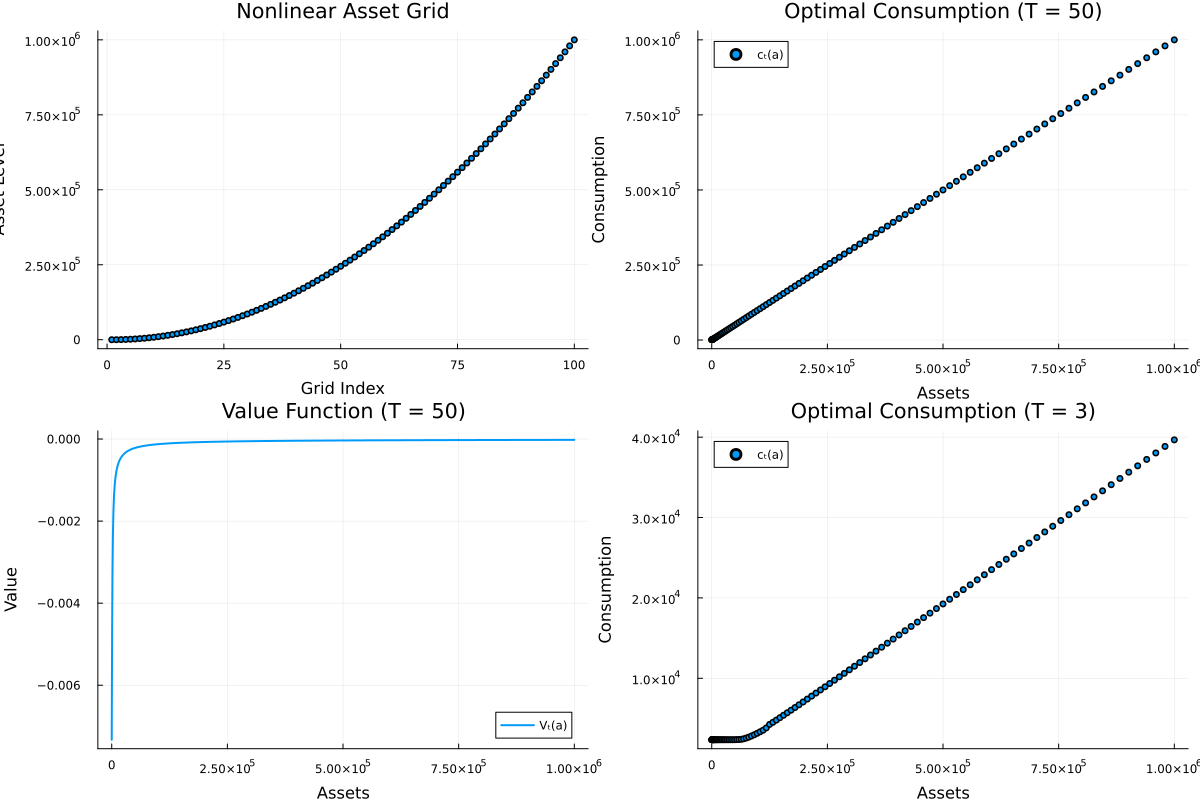

In [69]:

# Choose a representative labor grid index (e.g. the median)
k_mid = Int(ceil(length(model_baseline.k_grid)/2))
T_terminal = model_baseline.T  # Terminal period (e.g., 50)
t_early = 3          # An earlier period for comparison

# 1. Plot the nonlinear asset grid
p1 = scatter(1:length(model_baseline.a_grid), model_baseline.a_grid,
    xlabel = "Grid Index",
    ylabel = "Asset Level",
    title = "Nonlinear Asset Grid",
    legend = false,
    markersize = 3)

# 2. Plot optimal consumption policy at terminal period (T = model.T)
# Here we fix the labor dimension at k_mid.
p2 = scatter(model_baseline.a_grid, model_baseline.sol_c_college[T_terminal, :, k_mid],
    xlabel = "Assets",
    ylabel = "Consumption",
    title = "Optimal Consumption (T = $(T_terminal))",
    label = "cₜ(a)",
    markersize = 3)

# 3. Plot value function at terminal period (T = model.T)
# Note: use 'sol_v' (not sol_V) as per your definition.
p3 = plot(model_baseline.a_grid, model_baseline.sol_v_college[T_terminal, :, k_mid],
    xlabel = "Assets",
    ylabel = "Value",
    title = "Value Function (T = $(T_terminal))",
    label = "Vₜ(a)",
    linewidth = 2)

# 4. Plot optimal consumption policy at an earlier period (e.g., T = 10)
p4 = scatter(model_baseline.a_grid, model_baseline.sol_c_college[t_early, :, k_mid],
    xlabel = "Assets",
    ylabel = "Consumption",
    title = "Optimal Consumption (T = $(t_early))",
    label = "cₜ(a)",
    markersize = 3)

# Combine all plots into a 2×2 grid layout for comparison
plot(p1, p2, p3, p4, layout = (2, 2), size = (1200, 800))

In [68]:
# Counterfactual 1: Higher College Cost
# College cost is increased from 12000.0 to 15000.0 to simulate a scenario where attending college becomes more expensive, potentially reducing college attendance due to higher financial barriers.
model_cf1 = ConSavLaborCollege(college_cost=15000.0)
solve_model_college!(model_cf1)
solve_model_work!(model_cf1)
simulate_model!(model_cf1)

# Counterfactual 2: Lower College Cost
# College cost is decreased from 12000.0 to 9000.0 to simulate a scenario where college is more affordable, possibly increasing attendance by lowering the immediate cost of education.
model_cf2 = ConSavLaborCollege(college_cost=9000.0)
solve_model_college!(model_cf2)
solve_model_work!(model_cf2)
simulate_model!(model_cf2)

# Counterfactual 3: Higher College Boost
# College boost is increased from 4.0 to 5.0 to simulate a scenario where the productivity or wage gain from college is greater, making college more attractive due to higher future earnings.
model_cf3 = ConSavLaborCollege(college_boost=5.0)
solve_model_college!(model_cf3)
solve_model_work!(model_cf3)
simulate_model!(model_cf3)

# Counterfactual 4: Lower College Boost
# College boost is decreased from 4.0 to 3.0 to simulate a scenario where the benefit of college is reduced, potentially decreasing attendance as the return on education diminishes.
model_cf4 = ConSavLaborCollege(college_boost=3.0)
solve_model_college!(model_cf4)
solve_model_work!(model_cf4)
simulate_model!(model_cf4)

# Counterfactual 5: Higher Interest Rate
# Interest rate is increased from 0.02 to 0.03 to simulate a scenario with higher returns on savings or higher borrowing costs, which could affect college decisions by altering financing options or opportunity costs.
model_cf5 = ConSavLaborCollege(r=0.03)
solve_model_college!(model_cf5)
solve_model_work!(model_cf5)
simulate_model!(model_cf5)

# Counterfactual 6: Lower Interest Rate
# Interest rate is decreased from 0.02 to 0.01 to simulate a scenario with lower savings returns or borrowing costs, potentially making college more appealing if loans are cheaper.
model_cf6 = ConSavLaborCollege(r=0.01)
solve_model_college!(model_cf6)
solve_model_work!(model_cf6)
simulate_model!(model_cf6)

# Counterfactual 7: Higher Discount Factor
# Discount factor is increased from 0.96 to 0.98 to simulate a scenario where individuals value future consumption more (are more patient), possibly increasing college attendance due to greater emphasis on future earnings.
model_cf7 = ConSavLaborCollege(beta=0.98)
solve_model_college!(model_cf7)
solve_model_work!(model_cf7)
simulate_model!(model_cf7)

# Counterfactual 8: Lower Interest Rate (assuming typo correction to "Lower Discount Factor")
# Discount factor is decreased from 0.96 to 0.94 to simulate a scenario where individuals value future consumption less (are less patient), potentially reducing college attendance as immediate costs outweigh future benefits.
# Note: Original request said "Higher Discount Factor and lower interest rate"; assuming "lower discount factor" was intended to follow the pattern of pairs.
model_cf8 = ConSavLaborCollege(beta=0.94)
solve_model_college!(model_cf8)
solve_model_work!(model_cf8)
simulate_model!(model_cf8)

# Counterfactual 9: Lower Wage Rate
# Wage rate is decreased from 30000.0 to 25000.0 to simulate a scenario where earnings without college are lower, possibly increasing college attendance as the relative benefit of education rises.
model_cf9 = ConSavLaborCollege(w=25000.0)
solve_model_college!(model_cf9)
solve_model_work!(model_cf9)
simulate_model!(model_cf9)

# Counterfactual 10: Higher Wage Rate
# Wage rate is increased from 30000.0 to 35000.0 to simulate a scenario where earnings without college are higher, potentially decreasing college attendance due to a higher opportunity cost of not working.
model_cf10 = ConSavLaborCollege(w=35000.0)
solve_model_college!(model_cf10)
solve_model_work!(model_cf10)
simulate_model!(model_cf10)

# Counterfactual 11: Higher Discount Factor and Lower Interest Rate (Combined Scenario)
# Discount factor is increased from 0.96 to 0.98 and interest rate is decreased from 0.02 to 0.01 to simulate a combined scenario where individuals are more patient and face lower borrowing costs or savings returns, potentially increasing college attendance.
# Note: This follows the original phrasing "Higher Discount Factor and lower interest rate" as a combined change, differing from the single-parameter pattern of other pairs.
model_cf11 = ConSavLaborCollege(beta=0.98, r=0.01)
solve_model_college!(model_cf11)
solve_model_work!(model_cf11)
simulate_model!(model_cf11)

Solving college periods... 100%|█████████████████████████| Time: 0:00:15
Solving working model... 100%|███████████████████████████| Time: 0:00:16


Number choosing college: 535
Number choosing work: 4465


Solving college periods... 100%|█████████████████████████| Time: 0:00:15
Solving working model... 100%|███████████████████████████| Time: 0:00:16


Number choosing college: 1130
Number choosing work: 3870


Solving college periods... 100%|█████████████████████████| Time: 0:00:15
Solving working model... 100%|███████████████████████████| Time: 0:00:16


Number choosing college: 1131
Number choosing work: 3869


Solving college periods... 100%|█████████████████████████| Time: 0:00:15
Solving working model... 100%|███████████████████████████| Time: 0:00:16


Number choosing college: 337
Number choosing work: 4663


Solving college periods... 100%|█████████████████████████| Time: 0:00:14
Solving working model... 100%|███████████████████████████| Time: 0:00:15


Number choosing college: 231
Number choosing work: 4769


Solving college periods... 100%|█████████████████████████| Time: 0:00:15
Solving working model... 100%|███████████████████████████| Time: 0:00:16


Number choosing college: 1738
Number choosing work: 3262


Solving college periods... 100%|█████████████████████████| Time: 0:00:16
Solving working model... 100%|███████████████████████████| Time: 0:00:18


Number choosing college: 97
Number choosing work: 4903


Solving college periods... 100%|█████████████████████████| Time: 0:00:14
Solving working model... 100%|███████████████████████████| Time: 0:00:14


Number choosing college: 1836
Number choosing work: 3164


Solving college periods... 100%|█████████████████████████| Time: 0:00:15
Solving working model... 100%|███████████████████████████| Time: 0:00:15


Number choosing college: 601
Number choosing work: 4399


Solving college periods... 100%|█████████████████████████| Time: 0:00:15
Solving working model... 100%|███████████████████████████| Time: 0:00:16


Number choosing college: 1041
Number choosing work: 3959


Solving college periods... 100%|█████████████████████████| Time: 0:00:18
Solving working model... 100%|███████████████████████████| Time: 0:00:19


Number choosing college: 777
Number choosing work: 4223


ConSavLaborCollege(50, 4, 1.8, 0.98, 1.0, 0.5, 0.1, 30000.0, 0.25, 0.01, 1.0e6, 0.0, 100, 20.0, 50, 50, 5000, [0.0, 102.0304050607081, 408.1216202428324, 918.2736455463729, 1632.4864809713297, 2550.7601265177022, 3673.0945821854916, 4999.489847974696, 6529.945923885319, 8264.462809917355  …  826446.2809917354, 844913.7843077237, 863585.3484338332, 882460.9733700644, 901540.6591164167, 920824.4056728905, 940312.2130394859, 960004.0812162024, 979900.0102030407, 1.0e6], [0.0, 0.2765758830206044, 0.5928533835980518, 0.9260782572545605, 1.2708090474304825, 1.6243563569864896, 1.985092200714593, 2.3519178685515545, 2.7240388259740334, 3.100852211672241  …  15.998538033481742, 16.439043702805336, 16.880625188983544, 17.32325940691062, 17.76692429299541, 18.21159873773297, 18.65726252412913, 19.103896271353452, 19.551481383074695, 20.0], [981.7422215753693 981.6386127707556 … 28526.867007506695 29118.315255936934; 975.5153819170348 975.4992105678728 … 28926.926299956493 29528.049269822477; … ;